In [2]:
import matplotlib.pyplot as plt
import numpy as np
from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import (
    AdvancedIMU,
    Camera,
    Damage,
    Electrics,
    Lidar,
    State,
    Timer,
    Ultrasonic,
)

In [52]:
beamng = BeamNGpy("localhost", 25252)
beamng.open(launch=False)

In [4]:
beamng.get_levels()

{'automation_test_track': <beamngpy.scenario.level.Level at 0x77551810ba50>,
 'autotest': <beamngpy.scenario.level.Level at 0x77551810b410>,
 'c1': <beamngpy.scenario.level.Level at 0x77551810b390>,
 'Cliff': <beamngpy.scenario.level.Level at 0x77551810aed0>,
 'derby': <beamngpy.scenario.level.Level at 0x77551810ac10>,
 'driver_training': <beamngpy.scenario.level.Level at 0x77551810a3d0>,
 'east_coast_usa': <beamngpy.scenario.level.Level at 0x775518109c10>,
 'garage_v2': <beamngpy.scenario.level.Level at 0x775518108c10>,
 'glow_city': <beamngpy.scenario.level.Level at 0x775518108550>,
 'gridmap_v2': <beamngpy.scenario.level.Level at 0x77551810aa90>,
 'hirochi_raceway': <beamngpy.scenario.level.Level at 0x7755181082d0>,
 'Industrial': <beamngpy.scenario.level.Level at 0x775518111750>,
 'italy': <beamngpy.scenario.level.Level at 0x7755181083d0>,
 'johnson_valley': <beamngpy.scenario.level.Level at 0x775518112490>,
 'jungle_rock_island': <beamngpy.scenario.level.Level at 0x77551811c1d0>,


In [59]:
scenario = Scenario("c1", "beamngpy_feature_overview")
# scenario = Scenario(
#     "west_coast_usa",
#     "LiDAR_demo",
#     description="Spanning the map with a LiDAR sensor",
# )

ego = Vehicle("ego", model="etk800", color="White", license="PYTHON")
scenario.add_vehicle(
    ego, pos=(3794.3, 8799.8, 869.8), rot_quat=(0.0, 0.0, 0.96126170, 0.27563736)
)
# scenario.add_vehicle(
#     ego, pos=(-717.121, 101, 118.675), rot_quat=(0, 0, 0.3826834, 0.9238795)
# )
scenario.make(beamng)

In [60]:
beamng.scenario.load(scenario)
beamng.scenario.start()

In [6]:
camera = Camera(
    "camera1",
    beamng,
    ego,
    is_render_instance=True,
    is_render_annotations=True,
    is_render_depth=True,
    is_using_shared_memory=True
)

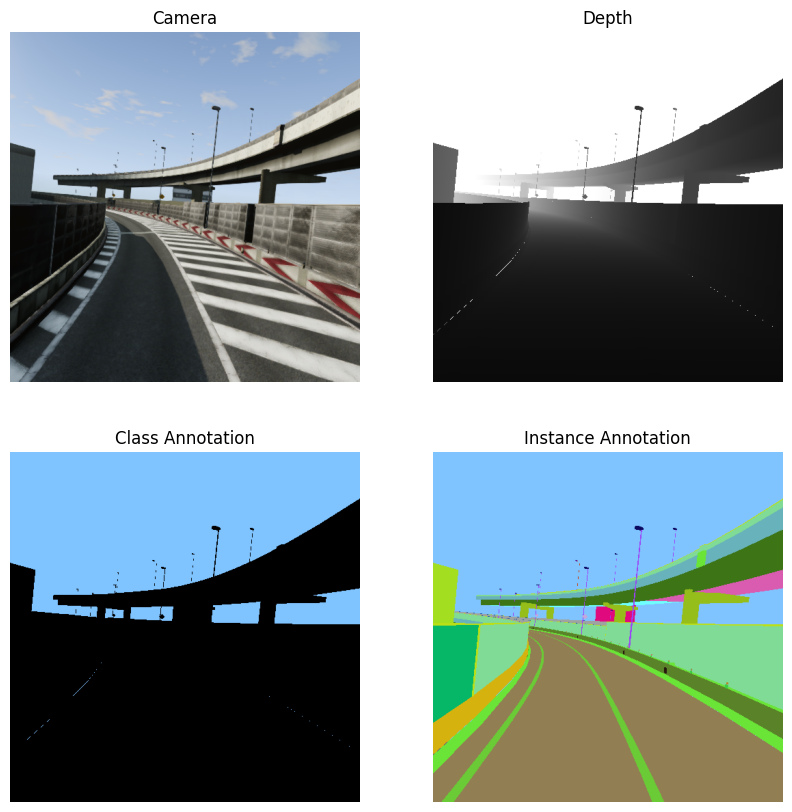

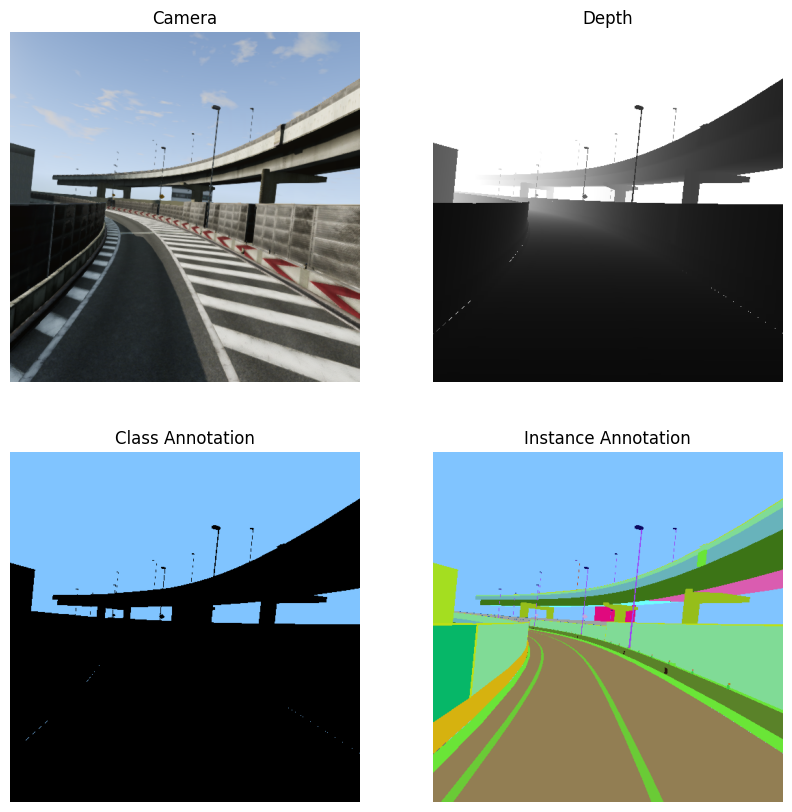

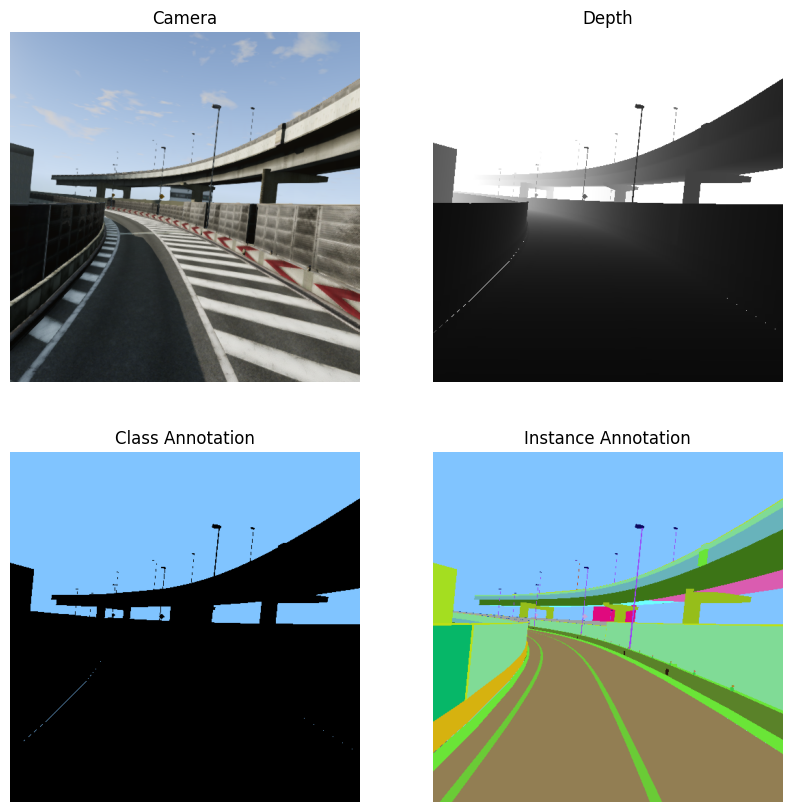

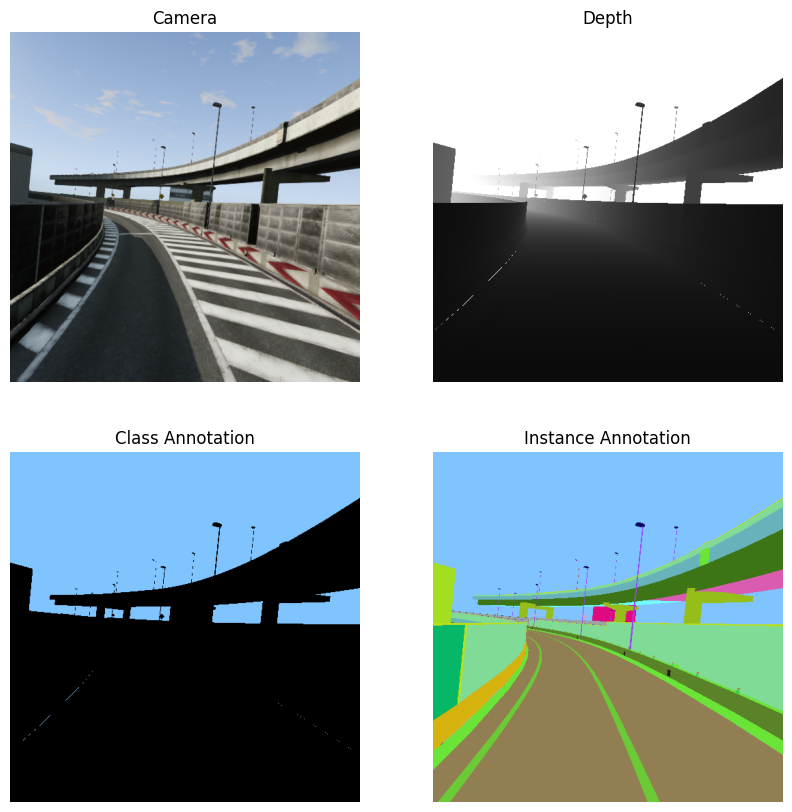

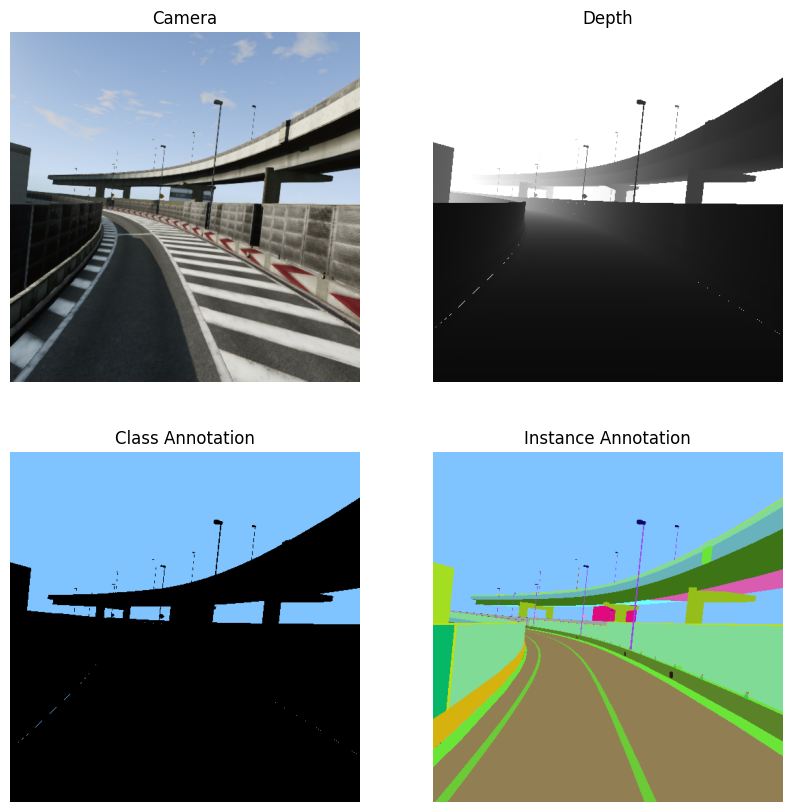

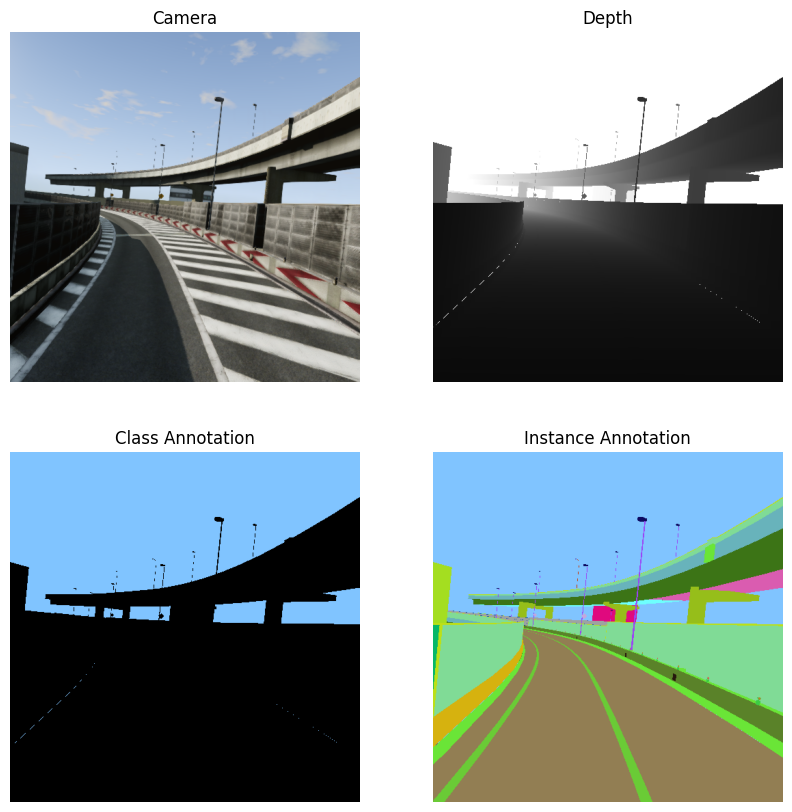

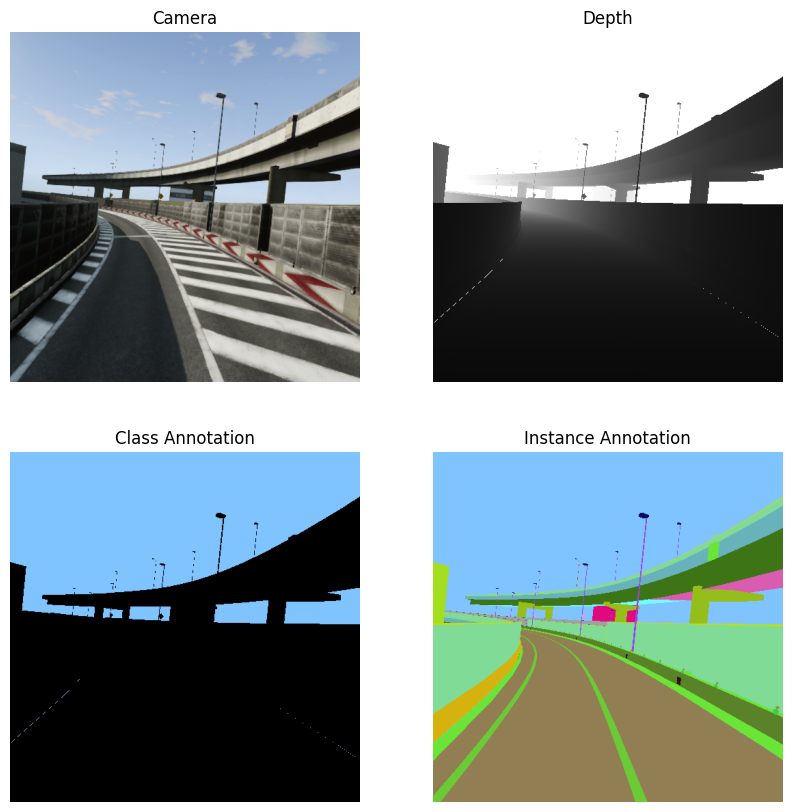

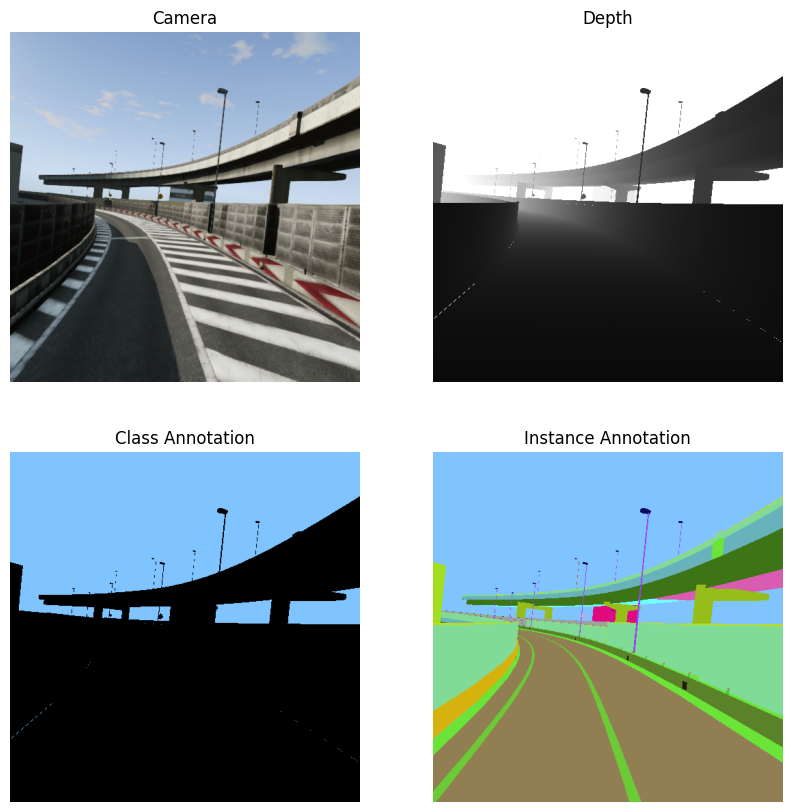

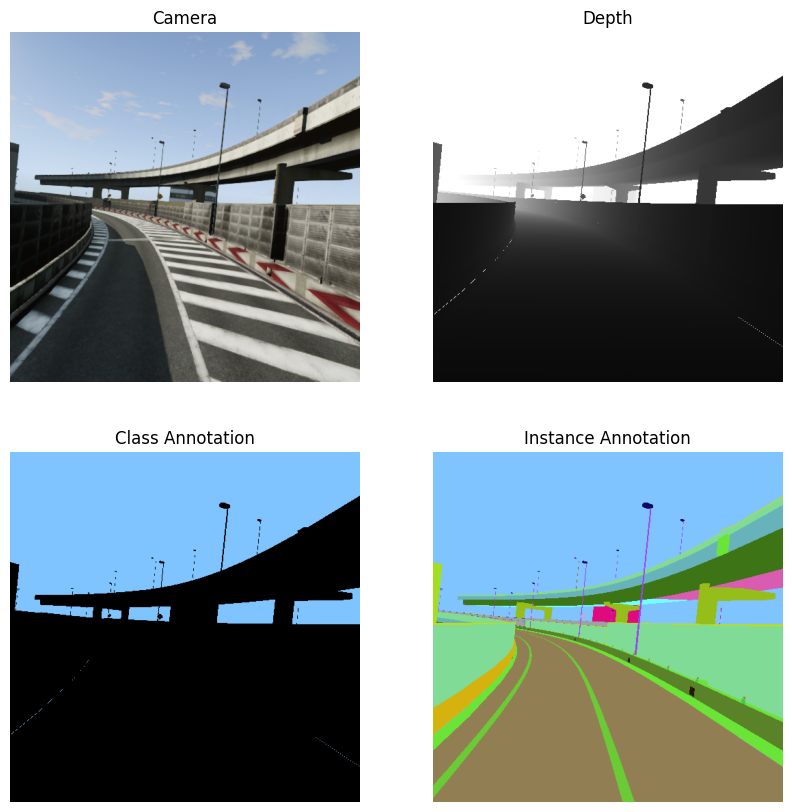

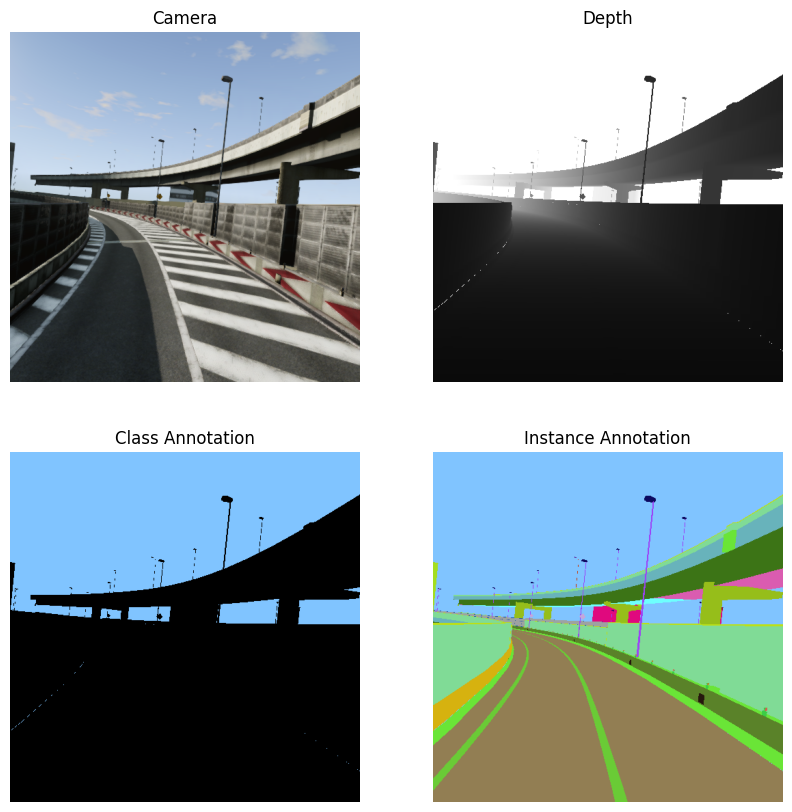

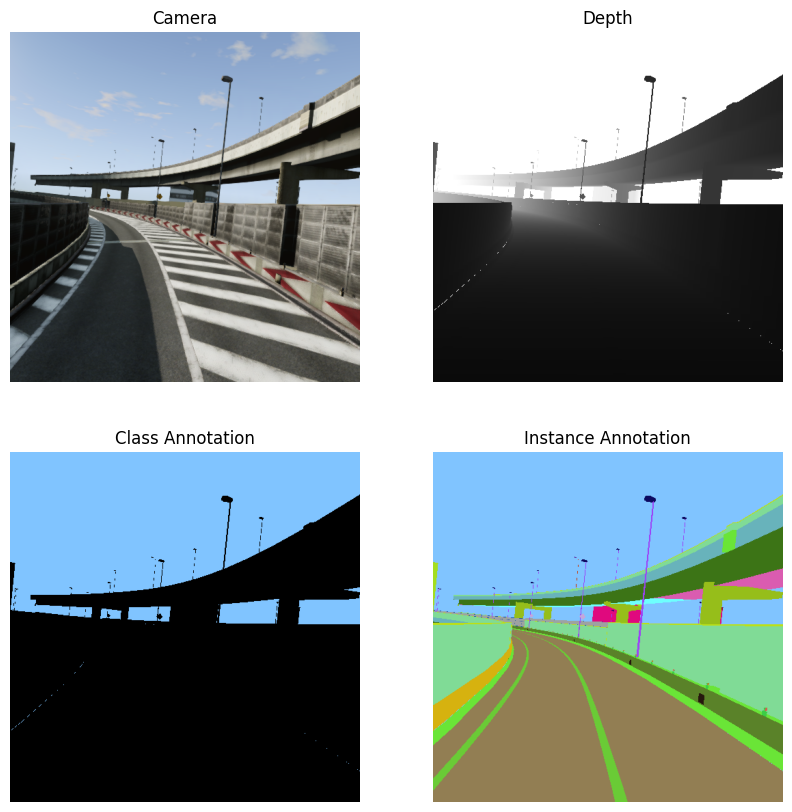

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
[axi.set_axis_off() for axi in ax.ravel()]
ax[0, 0].title.set_text("Camera")
ax[0, 1].title.set_text("Depth")
ax[1, 0].title.set_text("Class Annotation")
ax[1, 1].title.set_text("Instance Annotation")

for _ in range(10):
    data = camera.get_full_poll_request()
    ax[0, 0].imshow(np.asarray(data["colour"].convert("RGB")))
    ax[0, 1].imshow(np.asarray(data["depth"].convert("RGB")))
    ax[1, 0].imshow(np.asarray(data["annotation"].convert("RGB")))
    ax[1, 1].imshow(np.asarray(data["instance"].convert("RGB")))
    display(fig)

In [10]:
camera.remove()

In [14]:
lidar = Lidar("lidar1", beamng, ego, is_using_shared_memory=True, is_streaming=True, requested_update_time=0.05)

In [12]:
for _ in range(10):
    lidar_data = lidar.poll()
    print(lidar_data)

{'type': 'Lidar', 'pointCloud': array([[ 3.7381274e+03,  8.8615410e+03,  8.7071375e+02],
       [ 3.7381162e+03,  8.8615459e+03,  8.7071216e+02],
       [ 3.7381018e+03,  8.8615518e+03,  8.7070911e+02],
       ...,
       [-3.8921805e-18, -3.4907329e-01, -2.5793944e+07],
       [ 2.7608176e+20, -3.1981992e-07, -3.9275828e+05],
       [-2.4675389e+04, -8.5703541e-05, -7.5965660e+18]],
      shape=(150160, 3), dtype=float32), 'colours': array([[255,  33,   0, 255],
       [255,  34,   0, 255],
       [255,  34,   0, 255],
       ...,
       [208, 206, 200, 255],
       [206, 204, 198, 255],
       [222, 221, 217, 255]], shape=(150160, 4), dtype=uint8)}
{'type': 'Lidar', 'pointCloud': array([[ 3.7381274e+03,  8.8615410e+03,  8.7071375e+02],
       [ 3.7381162e+03,  8.8615459e+03,  8.7071216e+02],
       [ 3.7381018e+03,  8.8615518e+03,  8.7070911e+02],
       ...,
       [-3.8921805e-18, -3.4907329e-01, -2.5793944e+07],
       [ 2.7608176e+20, -3.1981992e-07, -3.9275828e+05],
       [-2.4

In [15]:
lidar.remove()

In [29]:
from beamngpy.sensors import RoadsSensor

In [39]:
rs = RoadsSensor("roadsensor", beamng, ego, physics_update_time=0.1)
frames = []


In [9]:
from time import sleep
import matplotlib.pyplot as plt

from beamngpy import BeamNGpy, Scenario, Vehicle, set_up_simple_logging, angle_to_quat
from beamngpy.sensors import RoadsSensor
from beamngpy.misc.vec3 import vec3

from matplotlib.animation import FuncAnimation

import numpy as np

GRANULARITY = 100

# Evaluates the road parametric cubic polynomials.
def discretize(d):
    eval_range = GRANULARITY + 1
    granularity_inv = 1.0 / GRANULARITY
    # Cache the individual coefficients of the u(p), v(p) equations, for the road centerline, the road left edge, and the road right edge.
    aU_CL, bU_CL, cU_CL, dU_CL = d["uAofCL"], d["uBofCL"], d["uCofCL"], d["uDofCL"]
    aV_CL, bV_CL, cV_CL, dV_CL = d["vAofCL"], d["vBofCL"], d["vCofCL"], d["vDofCL"]
    aU_LE, bU_LE, cU_LE, dU_LE = (
        d["uAofLeftRE"],
        d["uBofLeftRE"],
        d["uCofLeftRE"],
        d["uDofLeftRE"],
    )
    aV_LE, bV_LE, cV_LE, dV_LE = (
        d["vAofLeftRE"],
        d["vBofLeftRE"],
        d["vCofLeftRE"],
        d["vDofLeftRE"],
    )
    aU_RE, bU_RE, cU_RE, dU_RE = (
        d["uAofRightRE"],
        d["uBofRightRE"],
        d["uCofRightRE"],
        d["uDofRightRE"],
    )
    aV_RE, bV_RE, cV_RE, dV_RE = (
        d["vAofRightRE"],
        d["vBofRightRE"],
        d["vCofRightRE"],
        d["vDofRightRE"],
    )

    # Will evaluate each parametric cubic, discretized at the chosen granularity.
    pts_CL, pts_LE, pts_RE = [], [], []
    for i in range(eval_range):
        p = i * granularity_inv  # The parameter p, in [0, 1], and its powers.
        p2 = p * p
        p3 = p2 * p

        # Evaluate the polynomials.
        u_CL = (
            aU_CL + (p * bU_CL) + (p2 * cU_CL) + (p3 * dU_CL)
        )  # Road centerline u(p), v(p).
        v_CL = aV_CL + (p * bV_CL) + (p2 * cV_CL) + (p3 * dV_CL)
        u_LE = (
            aU_LE + (p * bU_LE) + (p2 * cU_LE) + (p3 * dU_LE)
        )  # Road left edge u(p), v(p).
        v_LE = aV_LE + (p * bV_LE) + (p2 * cV_LE) + (p3 * dV_LE)
        u_RE = (
            aU_RE + (p * bU_RE) + (p2 * cU_RE) + (p3 * dU_RE)
        )  # Road right edge u(p), v(p).
        v_RE = aV_RE + (p * bV_RE) + (p2 * cV_RE) + (p3 * dV_RE)

        pts_CL.append(
            vec3(u_CL, v_CL) + vec3(d["xStartCL"], d["yStartCL"])
        )  # Road centerline.
        pts_LE.append(
            vec3(u_LE, v_LE) + vec3(d["xStartL"], d["yStartL"])
        )  # Road left edge (with offset added horizontally).
        pts_RE.append(
            vec3(u_RE, v_RE) + vec3(d["xStartR"], d["yStartR"])
        )  # Road right edge (with offset added horizontally).

    return pts_CL, pts_LE, pts_RE


def update():
    sleep(1)
    print("in while...")
    d_raw = rs.poll()
    if not d_raw:
        print("No data received.")
        return
    d = d_raw[0]
    print("got raw data...")
    pts_CL, pts_LE, pts_RE = discretize(d)
    print("got discretized data...")
    ax.set(xlabel="x", ylabel="y", title="Road Profile")
    ax.set_aspect("equal", adjustable="box")
    print("to plot...")
    x, y = [], []  # Plot the road centerline.
    for i in range(len(pts_CL)):
        p = pts_CL[i]
        x.append(p.x)
        y.append(p.y)
    ax.plot(x, y, "b")
    x, y = [], []  # Plot the road left edge.
    for i in range(len(pts_LE)):
        p = pts_LE[i]
        x.append(p.x)
        y.append(p.y)
    ax.plot(x, y, "r")
    x, y = [], []  # Plot the road right edge.
    for i in range(len(pts_RE)):
        p = pts_RE[i]
        x.append(p.x)
        y.append(p.y)
    ax.plot(x, y, "g")
    plt.legend(["Centerline", "Left Edge", "Right Edge"])
    print("to get vehicle state...")
    ego.sensors.poll()  # Plot vehicle position and direction.
    pos = ego.state["pos"]
    dir = ego.state["dir"]
    vp = vec3(pos[0], pos[1])
    v1 = vp + vec3.normalize(vec3(dir[0], dir[1])) * 10.0
    v2 = v1 - vp
    ax.plot(vp.x, vp.y, "bo")
    plt.arrow(vp.x, vp.y, v2.x, v2.y, width=0.05)

    frames.append([ax.plot])

In [20]:
ego.ai.set_mode("traffic")

in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...


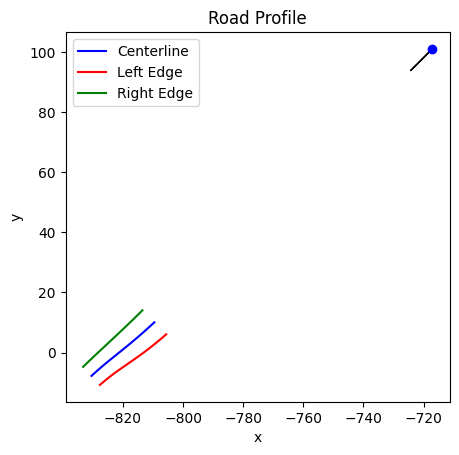

In [10]:
fig, ax = plt.subplots()
# Create the animation frames
# for k in range(20):
#     update()

update()
# Create the animation
animation = FuncAnimation(fig, update, frames, interval=50)
plt.show()

In [31]:
ax = frames[0][0]
ax

<bound method Axes.plot of <Axes: title={'center': 'Road Profile'}, xlabel='x', ylabel='y'>>

In [25]:
ego.ai.set_mode("disabled")

In [27]:
data = rs.poll()
data

{0.0: {'uDofRightRE': 0.8479226423216701,
  'vDofRightRE': -0.3742959611716001,
  'xStartL': 1737.0753487146,
  'time': 3667.1636741809,
  'vBofCL': -3.4326441946932,
  'numlane': 2.0,
  'zStartL': 861.67678718983,
  'zP1onCL': 861.81909179688,
  'roadRadius': 132.36274661624,
  'yStartL': 9782.8712248476,
  'uAofLeftRE': 0.0,
  'dist2Left': 17.078590177545,
  'xP1onCL': 1736.1704101563,
  'dist2Right': 17.173174664438,
  'uDofCL': 0.8858011427429701,
  'vDofCL': -0.38466450860062007,
  'xStartR': 1735.2654715979,
  'vAofRightRE': 0.0,
  'zP3onCL': 861.93103027344,
  'headingAngle': 0.0,
  'zP0onCL': 861.73590087891,
  'uCofCL': -1.1906951936051,
  'uBofCL': 10.95027979305,
  'vCofCL': 0.8426993282938402,
  'yP0onCL': 9784.255859375,
  'drivability': 1.0,
  'yP3onCL': 9773.9248046875,
  'yP1onCL': 9780.01171875,
  'xP2onCL': 1746.8157958984,
  'uBofLeftRE': 10.807554805517,
  'uDofLeftRE': 0.9232344329802901,
  'uCofLeftRE': -1.2449795815314,
  'vAofCL': 0.0,
  'flag1way': 1.0,
  'uAof

In [28]:
len(data)

1

In [51]:
d_raw = rs.poll()
d = d_raw[0]
ax = plt.figure().add_subplot(111)
print("got raw data...")
pts_CL, pts_LE, pts_RE = discretize(d)
print("got discretized data...")
ax.set(xlabel="x", ylabel="y", title="Road Profile")
ax.set_aspect("equal", adjustable="box")
print("to plot...")
x, y = [], []  # Plot the road centerline.
for i in range(len(pts_CL)):
    p = pts_CL[i]
    x.append(p.x)
    y.append(p.y)
ax.plot(x, y, "b")
x, y = [], []  # Plot the road left edge.
for i in range(len(pts_LE)):
    p = pts_LE[i]
    x.append(p.x)
    y.append(p.y)
ax.plot(x, y, "r")
x, y = [], []  # Plot the road right edge.
for i in range(len(pts_RE)):
    p = pts_RE[i]
    x.append(p.x)
    y.append(p.y)
ax.plot(x, y, "g")
plt.legend(["Centerline", "Left Edge", "Right Edge"])
print("to get vehicle state...")
ego.sensors.poll()  # Plot vehicle position and direction.
pos = ego.state["pos"]
dir = ego.state["dir"]
vp = vec3(pos[0], pos[1])
v1 = vp + vec3.normalize(vec3(dir[0], dir[1])) * 10.0
v2 = v1 - vp
ax.plot(vp.x, vp.y, "bo")
plt.arrow(vp.x, vp.y, v2.x, v2.y, width=0.05)
plt.show()

ConnectionRefusedError: [Errno 111] Connection refused

In [52]:
beamng.close()

In [61]:
# fetch road data from the game
roads = beamng.scenario.get_roads()
road_names = list(roads.keys())
road_spec = {}
for r_id, r_inf in roads.items():
    if r_inf["drivability"] != "-1":
        road_spec[r_id] = beamng.scenario.get_road_edges(r_id)

In [67]:
from shapely.geometry import MultiLineString
# put data into shapely MultilineString
road = list()
lines = list()
left_list = list()
right_list = list()

for r_id in road_spec.keys():
    left = list()
    right = list()
    for r_point in road_spec[r_id]:
        x = r_point["left"][0]
        y = r_point["left"][1]
        left.append((x, y))
        x = r_point["right"][0]
        y = r_point["right"][1]
        right.append((x, y))
    if left:
        lines.append(tuple(left))
        left_list.append(tuple(left))
    if right:
        lines.append(tuple(right))
        right_list.append(tuple(right))
network = MultiLineString(lines)
right_network = MultiLineString(right_list)
left_network = MultiLineString(left_list)

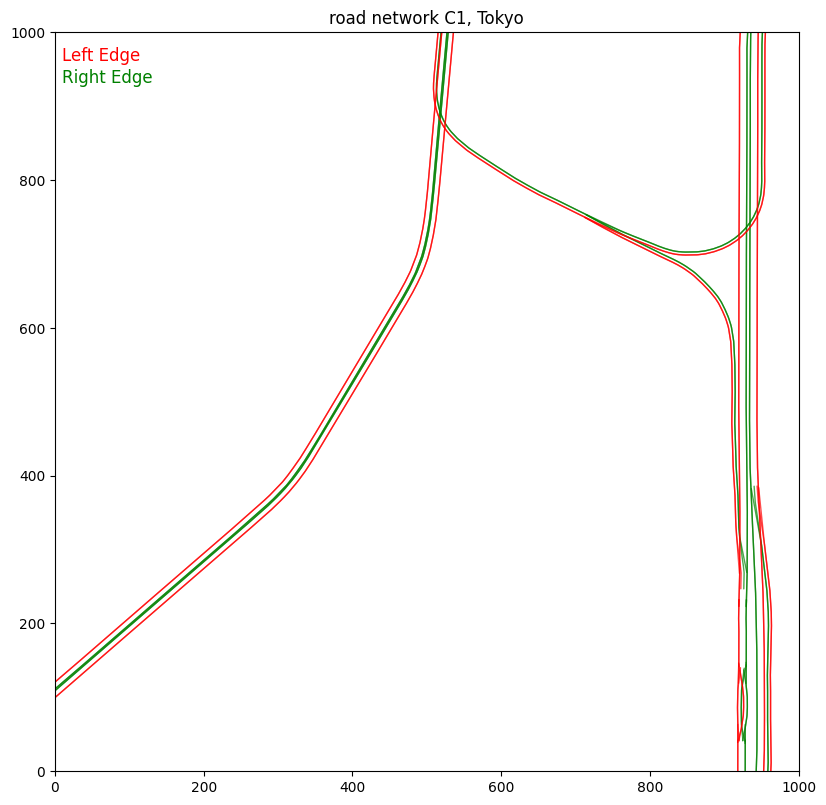

In [74]:
# plot map
def plot_lines(ax, ob, color="blue"):
    blue = "#6699cc"
    for line in ob.geoms:
        x, y = line.xy
        ax.plot(
            x, y, color=color, linewidth=1, solid_capstyle="round", zorder=2, alpha=0.7
        )


fig = plt.figure(1, figsize=[9.6, 9.6], dpi=100)

ax = fig.add_subplot()
# plot_lines(ax, network)
plot_lines(ax, right_network, color="green")
plot_lines(ax, left_network, color="red")

# _ = ax.set_axis_off()
# _ = ax.set_title("road network West Coast, USA")
_ = ax.set_title("road network C1, Tokyo")
# set label (red is left edge, green is right edge)
ax.text(10, 980, "Left Edge", color="red", fontsize=12, verticalalignment='top')
ax.text(10, 950, "Right Edge", color="green", fontsize=12, verticalalignment='top')
# zoom in
_ = ax.set_xlim(0, 1000)
_ = ax.set_ylim(0, 1000)
plt.show()
# plt.savefig("map_zoom.png")